In [1]:
import torch as t
import pandas as pd
# import numpy as np
# from tqdm import tqdm


from src.preprocess import *
from src.models import *
from src.utils import *

from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.simplefilter('ignore')


In [14]:
# setting up
DEVICE = 'cuda' if t.cuda.is_available() else 'cpu'
DEVICE = 'mps' if t.backends.mps.is_available() else DEVICE
params = {
    'DATASET_PATH' : './dataset/result.csv',
    'LOOK_FWD' : 700,
    'W_SIZE' : 400,
    'THR' : 0.000001,
    'TRAIN_TEST_R' : 0.8,
    'TRAIN_VAL_R' : 0.8,
    'HIDDEN' : 40,
    'N_LAYERS' : 5,
    'BATCH_SIZE' : 256,
    'SAMPLES' : 2000000,
}

locals().update(params)

In [3]:
import pickle

unzip_dataset('./dataset/')
pckl_name = './dataset/dataset.pckl'
if os.path.isfile(pckl_name):
    print('loading the dataset...')
    with open(pckl_name, 'rb') as f:
        dataset_ = pickle.load(f)
else: 
    dataset_ = pd.read_csv(DATASET_PATH, index_col=0)
    print('saving the dataset...')
    with open(pckl_name, 'wb+') as f:
        pickle.dump(dataset, f)

dataset = dataset_[:SAMPLES]
dataset.shape

Dataset already extracted
loading the dataset...


(2000000, 79)

In [4]:
labels_name = './dataset/labels.pckl'
if os.path.isfile(labels_name):
    with open('./dataset/labels.pckl', 'rb') as f:
        labels = pickle.load(f)
else:
    labels = generate_labels(dataset_, LOOK_FWD, THR)
    with open('./dataset/labels.pckl', 'wb+') as f:
        pickle.dump(labels, f)
        
labels = labels[LOOK_FWD:dataset.shape[0]]
dataset_ = None
labels.shape

(1999300,)

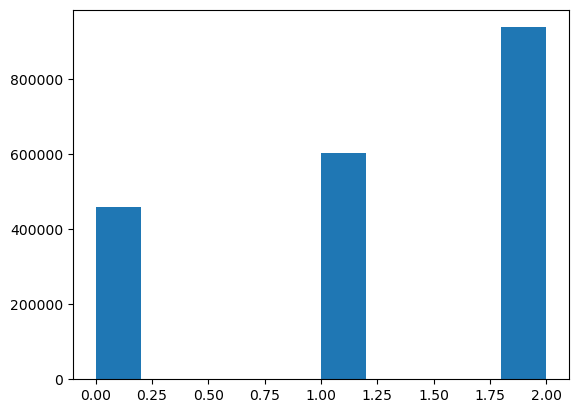

In [5]:
import matplotlib.pyplot as plt
plt.hist(labels)
plt.show()

In [6]:
labels.shape

(1999300,)

In [7]:
pipe = Pipe(W_SIZE)

train_index = int((dataset.shape[0] - LOOK_FWD * 2 - W_SIZE) * TRAIN_TEST_R)
test_index_start = train_index + W_SIZE
ds_train = dataset[:train_index]
ds_test = dataset[test_index_start: - LOOK_FWD * 2]

dataset = None

pipe.fit(ds_train)

train_t = pipe.transform(ds_train)
test_t = pipe.transform(ds_test)

train_l_t = t.tensor(labels[:train_t.shape[0]])
test_l_t = t.tensor(labels[test_index_start:test_index_start + test_t.shape[0]])

train_val_idx = int(train_l_t.shape[0] * TRAIN_VAL_R)

train_ds = t.utils.data.TensorDataset(train_t[:train_val_idx], train_l_t[:train_val_idx])
val_ds = t.utils.data.TensorDataset(train_t[train_val_idx:], train_l_t[train_val_idx:])
test_ds = t.utils.data.TensorDataset(test_t, test_l_t)

train_dl = t.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = t.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = t.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
model = Att_GRU(train_t.shape[2], 5, 20, W_SIZE, DEVICE).to(device=DEVICE)
model(train_t[500:505].to(device=DEVICE)).shape

torch.Size([5, 3])

In [9]:
model_1 = Att_GRU(test_t.shape[2],
                  n_layers=N_LAYERS,
                  hidden=HIDDEN,
                  device=DEVICE,
                  window=W_SIZE).to(device=DEVICE)
optimizer = t.optim.Adam(model.parameters(), lr=5e-4)
lf = t.nn.CrossEntropyLoss()
sm = SummaryWriter('./runs')

train(train_dl, val_dl, model, optimizer, lf, 30, device=DEVICE, sm=sm)
test_results = eval(test_dl, model, lf, DEVICE)
print(test_results)

train_loss: 0.914, train_acc_pre_rec: 0.626, 0.628, 0.626; || eval_loss: 1.013, eval_acc_pre_rec 0.515, 0.552, 0.515; || local_loss: 0.827: 100%|██████████| 30/30 [1:46:49<00:00, 213.64s/it]       


In [30]:
from datetime import datetime
import json

timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
t.save(model,'./models/train_gru_att_' + timestamp)
with open('./models/params_'+ timestamp, 'w+') as f:
    json.dump(params, f)
t.save(test_results, './models/test_scores_'+ timestamp)